In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import torch.nn as nn
import torch

from data_loader import GraphCancerMolecules, get_datasets, split_subset_data_loader
from data_loader import make_timestamp, split_data, kfold_split_data
from fast_delong_test import delong_roc_variance, delong_test
from arguments import get_args
from train import run_a_train_epoch, run_an_eval_epoch, set_device_and_set_seed, load_data
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from torch.nn import ELU
from fcd_torch import FCD
import json
from scipy import stats

from rdkit import Chem
from torch.utils.data import DataLoader
from mordred import Calculator, descriptors

from models import get_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor
import joblib

sns.set()
sns.set_context('talk')

Using backend: pytorch


## Train random forest model

In [2]:
# load_data(args)
new_args = {}
new_args['model_type'] = 'mlp_fingerprint'
new_args['grover_fp'] = 'none'
new_args["max_seq_len"] = 500
new_args["atom_pairs_fingerprints"] = True
new_args["torsion_fingerprints"] = False
new_args['fp_nbits'] = 256


new_args['training_carc_datasets'] = ('carc_caps_pred_el',)
new_args['training_mut_datasets'] = ()
new_args['held_out_test_carc_datasets'] = ("carc_ccris", )
new_args['held_out_test_mut_datasets'] = ()
new_args['out_feats'] = 1
new_args['fraction_of_data'] = 1
new_args['min_carbon_count'] = 3
new_args['use_carc_prob'] = False
new_args['carc_percentile_to_drop'] = 1

data, held_out_test_data = get_datasets(new_args)
list_of_data_tuples = kfold_split_data(data, k=3)


/Users/phil/anaconda3/envs/lm_rep/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
../src/data_loader.py:326: RuntimeWarning: Mean of empty slice
  beta_standardized = (betas - np.nanmean(betas)) / np.nanstd(betas)
/Users/phil/anaconda3/envs/lm_rep/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
../src/data_loader.py:328: RuntimeWarning: All-NaN slice encountered
  beta_normalized = betas - np.nanmin(betas)
../src/data_loader.py:329: RuntimeWarning: All-NaN slice encountered
  beta_normalized = beta_normalized / np.nanmax(beta_normalized)


To be dropped: Num multi molecules: 0, Num sequence exceeding length 0
(998, 11) 998


../src/data_loader.py:289: UserWarning: duplicated samples 14 contained in carcinogenicity data from ('carc_ccris',)
                                                smiles  carc_class      source
251   CC(C)CCCC(C)C1CCC2C3CC4OC45CC(O)CCC5(C)C3CCC12C           0  carc_ccris
812   CC(C)CCCC(C)C1CCC2C3CC4OC45CC(O)CCC5(C)C3CCC12C           0  carc_ccris
280                                   CCCCCC(O)C=CC=O           0  carc_ccris
1380                                  CCCCCC(O)C=CC=O           0  carc_ccris
1700             Cc1cc2ccccc2c2ccc3c(c12)C1OC1C(O)C3O           1  carc_ccris
  warnings.warn(f"duplicated samples {carc['smiles'].duplicated().sum()} contained in carcinogenicity data "
../src/data_loader.py:326: RuntimeWarning: Mean of empty slice
  beta_standardized = (betas - np.nanmean(betas)) / np.nanstd(betas)
/Users/phil/anaconda3/envs/lm_rep/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
../src/

To be dropped: Num multi molecules: 0, Num sequence exceeding length 0
(351, 11) 351
Start initializing RDKit molecule instances...
Start computing Bemis-Murcko scaffolds.
Processing fold 1/3
Processing fold 2/3
Processing fold 3/3


In [3]:

X = np.array([x.numpy() for x in data.fingerprints])
y = np.array([x.numpy() for x in data.carc_labels])
print(X.shape, y.shape)

CV_search = False
if CV_search:
    clf = RandomForestClassifier(max_depth=200, random_state=0, oob_score=True,n_estimators=100)

    n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1600, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}

    rf_random = RandomizedSearchCV(
        estimator = clf, param_distributions = random_grid,
        n_iter = 50, cv = 3, verbose=2, random_state=0, n_jobs = -1
    )# Fit the random search model
    rf_random.fit(X, y)

    rf_random.best_params_

(998, 935) (998,)


In [4]:
load_model=True
if load_model:
    clf = joblib.load("../models/in_house_rf.joblib")
else:
    clf=RandomForestClassifier(**rf_random.best_params_, oob_score=True, random_state=0)
    clf.fit(X, y)

data.df['in_house_rf_pred_oob'] = clf.oob_decision_function_[:, 1]
carc_pred_el_df = data.df

save_model=False
if save_model:
    joblib.dump(clf, "../models/in_house_rf_new.joblib")


## Train AdaBoost with mordred fingerprints

In [5]:
# load_data(args)
new_args = {}
new_args['model_type'] = 'mlp_fingerprint'
new_args['grover_fp'] = 'none'
new_args["max_seq_len"] = 500
new_args["atom_pairs_fingerprints"] = True
new_args["torsion_fingerprints"] = False
new_args['fp_nbits'] = 256


new_args['training_carc_datasets'] = ('carc_cpdb',)
new_args['training_mut_datasets'] = ()
new_args['held_out_test_carc_datasets'] = ("carc_ccris", 'carc_caps_pred_el')
new_args['held_out_test_mut_datasets'] = ()
new_args['out_feats'] = 1
new_args['fraction_of_data'] = 1
new_args['min_carbon_count'] = 3
new_args['use_carc_prob'] = False
new_args['carc_percentile_to_drop'] = 1

recompute_mordred_data=False
data, held_out_test_data = get_datasets(new_args)
calc = Calculator(descriptors, ignore_3D=True)
# Subset to molecules only in test set
held_out_test_data.df = held_out_test_data.df[~held_out_test_data.df['smiles'].isin(data.df['smiles'])]

if recompute_mordred_data:
    
    assert data.df['beta_standardized'].isnull().sum()  == 0
    assert held_out_test_data.df['carc_class'].isnull().sum()  == 0

    # Generate mordred predictions for held out test
    held_out_mols = [Chem.MolFromSmiles(x) for x in held_out_test_data.df['smiles']]
    mordred_fp_held_out = calc.pandas(held_out_mols)
    mordred_fp_held_out['carc_class'] = held_out_test_data.df['carc_class']
    mordred_fp_held_out['smiles'] = held_out_test_data.df['smiles']
    
    data_mols = [Chem.MolFromSmiles(x) for x in data.df['smiles']]
    mordred_fp_data = calc.pandas(data_mols)
    mordred_fp_data['beta_standardized'] = data.df['beta_standardized']
    mordred_fp_data['smiles'] = data.df['smiles']
    
    mordred_fp_held_out.to_csv('../data/mordred_held_out.csv', index=False)
    mordred_fp_data.to_csv('../data/mordred_data.csv', index=False)

else:
    mordred_fp_held_out = pd.read_csv('../data/mordred_held_out.csv')
    mordred_fp_data = pd.read_csv('../data/mordred_data.csv')

list_of_data_tuples = kfold_split_data(data, k=3)


To be dropped: Num multi molecules: 0, Num sequence exceeding length 0
(1033, 12) 1033


../src/data_loader.py:289: UserWarning: duplicated samples 14 contained in carcinogenicity data from ('carc_ccris', 'carc_caps_pred_el')
                                                smiles  carc_class      source
251   CC(C)CCCC(C)C1CCC2C3CC4OC45CC(O)CCC5(C)C3CCC12C           0  carc_ccris
812   CC(C)CCCC(C)C1CCC2C3CC4OC45CC(O)CCC5(C)C3CCC12C           0  carc_ccris
280                                   CCCCCC(O)C=CC=O           0  carc_ccris
1380                                  CCCCCC(O)C=CC=O           0  carc_ccris
1700             Cc1cc2ccccc2c2ccc3c(c12)C1OC1C(O)C3O           1  carc_ccris
  warnings.warn(f"duplicated samples {carc['smiles'].duplicated().sum()} contained in carcinogenicity data "
../src/data_loader.py:326: RuntimeWarning: Mean of empty slice
  beta_standardized = (betas - np.nanmean(betas)) / np.nanstd(betas)
/Users/phil/anaconda3/envs/lm_rep/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdi

To be dropped: Num multi molecules: 0, Num sequence exceeding length 0
(1349, 11) 1349


/Users/phil/anaconda3/envs/lm_rep/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (233,234,235,236,237,238,239,240,241,341,342,343,344,345,449,450,451,452,545,546,547,548,641,642,780,781,1582) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/phil/anaconda3/envs/lm_rep/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (139,148,157,166,175,184,193,202,211,220,229,233,234,235,236,237,238,239,240,241,341,342,343,344,345,346,355,364,373,382,391,400,409,418,427,436,445,449,450,451,452,453,461,469,477,485,493,501,509,517,525,533,541,545,546,547,548,549,557,565,573,581,589,597,605,613,621,629,637,641,642,780,781,828,829,844,845,1301,1363,1364,1582) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Start initializing RDKit molecule instances...
Creating RDKit molecule instance 1000/1033
Start computing Bemis-Murcko scaffolds.
Computing Bemis-Murcko for compound 1000/1033
Processing fold 1/3
Processing fold 2/3
Processing fold 3/3


In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

mordred_fp_held_out_columns = mordred_fp_held_out.select_dtypes(include=numerics).columns
mordred_fp_data_columns = mordred_fp_data.select_dtypes(include=numerics).columns

# Take the intersection of two sets of columns
mordfred_fp_columns = list(
    set(mordred_fp_data_columns).intersection(set(mordred_fp_held_out_columns))
)

# During intersection will remove the carc label & beta_standardized
X = mordred_fp_data[mordfred_fp_columns].values
X_held_out = mordred_fp_held_out[mordfred_fp_columns].values
y = mordred_fp_data['beta_standardized'].values
y_held_out = mordred_fp_held_out['carc_class'].values


In [7]:
load_model = False

for fold_i, (train, val) in enumerate(list_of_data_tuples):
    print(f"fold: {fold_i}")
    val, test, _ = split_subset_data_loader(val, train_fraction=0.5, val_fraction=0.5, test_fraction=0)
    test_df = test.dataset.df.loc[test.indices]
    val_df = val.dataset.df.loc[val.indices]
    train_df = train.dataset.df.loc[train.indices]

    assert train_df['smiles'].isin(val_df['smiles']).sum() == 0
    assert val_df['smiles'].isin(test_df['smiles']).sum() == 0
    assert train_df['smiles'].isin(test_df['smiles']).sum() == 0

    X_train = X[train.indices, :]
    y_train = y[train.indices]

    X_val = X[val.indices, :]
    y_val = y[val.indices]

    X_test = X[test.indices, :]
    y_test = y[test.indices]    

    if load_model:
        regr = joblib.load(f"../models/in_house_adaboost_{fold_i}.joblib")
    else:
        regr = AdaBoostRegressor(random_state=0, n_estimators=100)
        regr.fit(X_train, y_train)
        joblib.dump(regr, f"../models/in_house_adaboost_{fold_i}.joblib")
    
    val_pred = regr.predict(X_val)
    test_pred = regr.predict(X_test)
    
    data.df.loc[test.indices, "ada_boost_pred"] = test_pred
    data.df.loc[val.indices, "ada_boost_pred"] = val_pred
    
held_out_pred = regr.predict(X_held_out)
held_out_test_data.df[f'ada_boost_pred'] = held_out_pred

ada_df = data.df[['smiles', 'ada_boost_pred']]
ada_held_out = held_out_test_data.df[['smiles', 'ada_boost_pred']]

ada_df = pd.concat([ada_df, ada_held_out])

fold: 0
fold: 1
fold: 2


## Load CONCERTO predictions and join RF and Adaboost

In [8]:
directory = '../results/'
timestamp='2021_08_25_08_33_05_2'
with open(f'{directory}{timestamp}_config_0.json') as fin:
        config = json.load(fin)
args= config
args['training_carc_datasets']=('all_data',)
args['training_mut_datasets']=()
args['model_type'] = 'mlp_fingerprint'
args["atom_pairs_fingerprints"] = True
args["torsion_fingerprints"] = False
args['fp_nbits'] = 256

train, _ = get_datasets(args)

X = np.array([x.numpy() for x in train.fingerprints])
y = np.array([x.numpy() for x in train.carc_labels])

train.df['in_house_rf_pred'] = clf.predict_proba(X)[:, 1]

carcino_pred = pd.read_csv('../data/carcino_pred_el_concerto_pred.csv')
df = train.df.merge(carcino_pred, on='smiles', how='left')

df = pd.merge(left=df, right=carc_pred_el_df[['smiles', 'in_house_rf_pred_oob']], on='smiles', how='left')

# assign out of bag values to predictions that it was trained on
df.loc[
    df['in_house_rf_pred_oob'].notnull(), 'in_house_rf_pred'
] = df[df['in_house_rf_pred_oob'].notnull()]['in_house_rf_pred_oob']

df.drop(columns=['in_house_rf_pred_oob'], inplace=True)

# merge with adaboost results
len_df = len(df)
df = pd.merge(left=df, right=ada_df[['smiles', 'ada_boost_pred']], on='smiles', how='left')
assert len(df) == len_df

assert df['smiles'].duplicated().sum() == 0

../src/data_loader.py:289: UserWarning: duplicated samples 800 contained in carcinogenicity data from ('carc_cpdb', 'carc_ccris', 'all_data', 'carc_caps_pred_el')
              cas      td50                                 smiles  carc_class_multi  carc_class        source
803          NaN       NaN  Brc1cc(-c2ccc(Br)c(Br)c2Br)cc(Br)c1Br               NaN         0.0  caps_pred_el
904   59536-65-1  3.764010  Brc1cc(-c2ccc(Br)c(Br)c2Br)cc(Br)c1Br               3.0         1.0          cpdb
802          NaN       NaN  Brc1cc(Br)c(-c2cc(Br)c(Br)cc2Br)cc1Br               NaN         1.0  caps_pred_el
1372  67774-32-7  0.347103  Brc1cc(Br)c(-c2cc(Br)c(Br)cc2Br)cc1Br               4.0         1.0          cpdb
33    34522-69-5  7.500451                   Brc1cc(Br)c2cccnc2c1               2.0         1.0          cpdb
  warnings.warn(f"duplicated samples {carc['smiles'].duplicated().sum()} contained in carcinogenicity data "


To be dropped: Num multi molecules: 0, Num sequence exceeding length 0
(1596, 13) 1487


../src/data_loader.py:282: UserWarning: duplicated samples 122 contained in mutagenicity data from ['mut_li', 'mut_ccris']
                                      smiles  mut_class     source
974   Brc1cc(Br)c(-c2cc(Br)c(Br)cc2Br)cc1Br        0.0         li
1234  Brc1cc(Br)c(-c2cc(Br)c(Br)cc2Br)cc1Br        0.0  mut_ccris
1233                           C1=CCCC=CCC1        1.0         li
1232                           C1=CCCC=CCC1        0.0         li
119                            C1=CCCC=CCC1        0.0         li
  warnings.warn(f"duplicated samples {mut['smiles'].duplicated().sum()} contained in mutagenicity data "
../src/data_loader.py:289: UserWarning: duplicated samples 14 contained in carcinogenicity data from ['carc_ccris']
                                                smiles  carc_class      source
251   CC(C)CCCC(C)C1CCC2C3CC4OC45CC(O)CCC5(C)C3CCC12C           0  carc_ccris
812   CC(C)CCCC(C)C1CCC2C3CC4OC45CC(O)CCC5(C)C3CCC12C           0  carc_ccris
280                     

To be dropped: Num multi molecules: 0, Num sequence exceeding length 1
(1174, 12) 1172


In [9]:
def load_data_eval(dataset='held_out_test_0'):
    
    cnn1_baseline = pd.read_csv(f'../results/cnn_baseline/2021_11_03_13_00_54_2/{dataset}.csv')
    cnn2_baseline = pd.read_csv(f'../results/cnn_baseline/2021_11_03_11_24_56_2/{dataset}.csv')
    cnn3_baseline = pd.read_csv(f'../results/cnn_baseline/2021_11_03_12_06_06_2/{dataset}.csv')

    cnn_baseline = pd.merge(
        cnn1_baseline, cnn2_baseline[['smiles', 'carc_pred']],
        on='smiles', suffixes=['_1', '_2'])
    cnn_baseline = pd.merge(
        cnn_baseline, cnn3_baseline[['smiles', 'carc_pred']],
        on='smiles')
    cnn_baseline = cnn_baseline.rename(columns={'carc_pred': 'carc_pred_3'})
    cnn_baseline['carc_pred_cnn_baseline'] = (
        cnn_baseline['carc_pred_1'] + 
        cnn_baseline['carc_pred_2'] + 
        cnn_baseline['carc_pred_3'])/3

    fp1_baseline = pd.read_csv(f'../results/fp_baseline/2021_11_04_10_50_53_2/{dataset}.csv')
    fp2_baseline = pd.read_csv(f'../results/fp_baseline/2021_11_04_11_58_06_2/{dataset}.csv')
    fp3_baseline = pd.read_csv(f'../results/fp_baseline/2021_11_04_12_08_11_2/{dataset}.csv')

    fp_baseline = pd.merge(
        fp1_baseline, fp2_baseline[['smiles', 'carc_pred']],
        on='smiles', suffixes=['_1', '_2'])
    fp_baseline = pd.merge(
        fp_baseline, fp3_baseline[['smiles', 'carc_pred']],
        on='smiles')
    fp_baseline = fp_baseline.rename(columns={'carc_pred': 'carc_pred_3'})
    fp_baseline['carc_pred_fp_baseline'] = (
        fp_baseline['carc_pred_1'] + 
        fp_baseline['carc_pred_2'] + 
        fp_baseline['carc_pred_3'])/3
    
    fp_baseline = pd.read_csv(f'../results/fp_baseline/2021_11_04_15_07_41_2/{dataset}.csv')
    fp_baseline['carc_pred_fp_baseline'] = fp_baseline['carc_pred']    
    grover_baseline = pd.read_csv(f'../results/grover_baseline/2021_11_04_17_10_14_2/{dataset}.csv')
    grover_baseline['carc_pred_grover'] = grover_baseline['carc_pred']

    
    cnn1 = pd.read_csv(f'../results/cnn/2021_08_26_21_20_44_2/{dataset}.csv')
    cnn2 = pd.read_csv(f'../results/cnn/2021_08_25_21_49_37_2/{dataset}.csv')
    cnn3 = pd.read_csv(f'../results/cnn/2021_08_27_07_47_27_2/{dataset}.csv')
    cnn = pd.merge(cnn1, cnn2[['smiles', 'carc_pred']], on='smiles', suffixes=['_1', '_2'])
    cnn = pd.merge(cnn, cnn3[['smiles', 'carc_pred']], on='smiles')
    cnn = cnn.rename(columns={'carc_pred': 'carc_pred_3'})
    cnn['carc_pred_cnn'] = (cnn['carc_pred_1'] + cnn['carc_pred_2'] + cnn['carc_pred_3'])/3


    fp1 = pd.read_csv(f'../results/mlp_fp/2021_09_08_05_32_35_2/{dataset}.csv')
    fp2 = pd.read_csv(f'../results/mlp_fp/2021_09_08_04_06_24_2/{dataset}.csv')
    fp3 = pd.read_csv(f'../results/mlp_fp/2021_09_08_01_07_51_2/{dataset}.csv')
    fp = pd.merge(fp1, fp2[['smiles', 'carc_pred']], on='smiles', suffixes=['_1', '_2'])
    fp = pd.merge(fp, fp3[['smiles', 'carc_pred']], on='smiles')
    fp = fp.rename(columns={'carc_pred': 'carc_pred_3'})
    fp['carc_pred_fp'] = (fp['carc_pred_1'] + fp['carc_pred_2'] + fp['carc_pred_3'])/3


    gin1 = pd.read_csv(f'../results/gin/2021_08_25_08_33_05_2/{dataset}.csv')
    gin2 = pd.read_csv(f'../results/gin/2021_08_24_16_20_49_2/{dataset}.csv')
    gin3 = pd.read_csv(f'../results/gin/2021_08_25_09_28_13_2/{dataset}.csv')
    gin = pd.merge(gin1, gin2[['smiles', 'carc_pred']], on='smiles', suffixes=['_gin_1', '_gin_2'])
    gin = pd.merge(gin, gin3[['smiles', 'carc_pred']], on='smiles')
    gin = gin.rename(columns={'carc_pred': 'carc_pred_gin_3'})
    gin['carc_pred_gin'] = (gin['carc_pred_gin_1'] + 
                            gin['carc_pred_gin_2'] + gin['carc_pred_gin_3'])/3
    
    gat1 = pd.read_csv(f'../results/gat/2021_10_15_14_49_27_2/{dataset}.csv')
    gat2 = pd.read_csv(f'../results/gat/2021_10_13_13_11_27_2/{dataset}.csv')
    gat3 = pd.read_csv(f'../results/gat/2021_10_15_13_51_19_2/{dataset}.csv')
    gat = pd.merge(gat1, gat2[['smiles', 'carc_pred']], on='smiles', suffixes=['_1', '_2'])
    gat = pd.merge(gat, gat3[['smiles', 'carc_pred']], on='smiles')
    gat = gat.rename(columns={'carc_pred': 'carc_pred_3'})
    gat['carc_pred_gat'] = (gat['carc_pred_1'] + gat['carc_pred_2'] + cnn['carc_pred_3'])/3

    return gin, cnn, fp, gat, cnn_baseline, grover_baseline, fp_baseline

def combine_data(gin, cnn, fp, gat, cnn_baseline, grover, fp_baseline, include_grover=False, df=df):
    held_out_eval = pd.merge(
    cnn[['smiles', 'carc_pred_cnn',
         'carc_continuous', 'carc_label', 'mut_label']],
    df[['smiles', 'rf_pred', 'CDK', 'Pubchem', 'in_house_rf_pred', 'ada_boost_pred']],
    on='smiles'
    )
    held_out_eval = held_out_eval.merge(
        gin[['smiles', 'carc_pred_gin']], on='smiles'
    )
    held_out_eval = held_out_eval.merge(
        fp[['smiles', 'carc_pred_fp']], on='smiles'
    )
    held_out_eval = held_out_eval.merge(
        gat[['smiles', 'carc_pred_gat']], on='smiles'
    )
    held_out_eval = held_out_eval.merge(
        cnn_baseline[['smiles', 'carc_pred_cnn_baseline']], on='smiles'
    )
    if include_grover:
        held_out_eval = held_out_eval.merge(
            grover[['smiles', 'carc_pred_grover']], on='smiles'
        )
    held_out_eval = held_out_eval.merge(
        fp_baseline[['smiles', 'carc_pred_fp_baseline']], on='smiles'
    )

    return held_out_eval

In [10]:
held_out_eval = combine_data(*load_data_eval('held_out_test_0'), include_grover=True, df=df)
viz_predictors = [
    'carc_pred_fp',
#     'carc_pred_cnn_baseline',
#     'carc_pred_gin',
#     'carc_pred_gat',
#     'CDK',
    'carc_pred_fp_baseline',
    'carc_pred_grover',
    'rf_pred',
#     'Pubchem',
#     'in_house_rf_pred',
    'ada_boost_pred'

]

predictors = [
    'carc_pred_cnn',
    'carc_pred_fp',
    'carc_pred_cnn_baseline',
    'carc_pred_gin',
    'carc_pred_gat',
    'rf_pred', 
    'carc_pred_fp_baseline',
    'carc_pred_grover',
    'Pubchem',
    'in_house_rf_pred',
    'ada_boost_pred'
]
held_out_carc = held_out_eval[
    (held_out_eval['carc_label'].notnull())
    & (held_out_eval['CDK'].notnull())
]

held_out_mut = held_out_eval[
    (held_out_eval['mut_label'].notnull())
    & (held_out_eval['CDK'].notnull())
]

print(len(held_out_carc))
print(len(held_out_mut))

201
155


In [11]:
def bootstrap(func, array1, array2, itrs = 100):
    outputs = []
    for _ in range(itrs):
        new_index1 = np.random.choice(np.arange(len(array1)), len(array1))
        new_index1 = np.sort(new_index1)
        outputs.append(
            func(array1[new_index1], array2[new_index1])
        )
    return outputs

In [12]:
def computer_pr_roc_auc(prediction, labels, name):
        precision, recall, thresholds = precision_recall_curve(labels, prediction)
        auc_value = auc(recall, precision)
        assert len(recall) == len(precision)
        outputs_roc = bootstrap(auc, recall, precision)
        auc_value_mean = np.mean(outputs_roc)
        auc_value_std = np.std(outputs_roc)
        print(f'{name} PR AUC: ${auc_value_mean:.2f} \pm {auc_value_std:.2f}$')
        fpr, tpr, thresholds = roc_curve(labels, prediction)
        auc_value = auc(fpr, tpr)
        assert len(fpr) == len(tpr)
        outputs_pr = bootstrap(auc, fpr, tpr)
        auc_value_mean = np.mean(outputs_pr)
        auc_value_std = np.std(outputs_pr)
        print(f'{name} ROC AUC: ${auc_value_mean:.2f} \pm {auc_value_std:.2f}$')
        return outputs_roc, outputs_pr

def add_pr_plot(prediction, labels, name, linestyle='solid', add_auc=False):
    precision, recall, thresholds = precision_recall_curve(labels, prediction)
    auc_value = auc(recall, precision)
    assert len(recall) == len(precision)
    outputs = bootstrap(auc, recall, precision)
    auc_value_mean = np.mean(outputs)
    auc_value_std = np.std(outputs)
    
        
    if add_auc:
        label=f'{name} AUC: {auc_value_mean:.2f} ± {auc_value_std:.2f}'
    else:
        print(f'{name} AUC: ${auc_value_mean:.2f} \pm {auc_value_std:.2f}$')
        label=f'{name}'


    plt.step(
        recall, precision,
        linestyle=linestyle,
        where='post', label=label
    )
    
def add_roc_plot(prediction, labels, name, linestyle='solid', add_auc=False, return_outputs=False):
    fpr, tpr, thresholds = roc_curve(labels, prediction)
    auc_value = auc(fpr, tpr)
    assert len(fpr) == len(tpr)
    outputs = bootstrap(auc, fpr, tpr)
    auc_value_mean = np.mean(outputs)
    auc_value_std = np.std(outputs)
    
    if add_auc:
        label=f'{name} AUC: {auc_value_mean:.2f} ± {auc_value_std:.2f}'
    else:
        print(f'{name} AUC: ${auc_value_mean:.2f} \pm {auc_value_std:.2f}$')
        label=f'{name}'

    plt.step(
        fpr, tpr, 
        linestyle=linestyle,
        where='post', 
        label=label
    )
    if return_outputs:
        temp = pd.DataFrame({'tpr': tpr, 'fpr': fpr})
        return temp

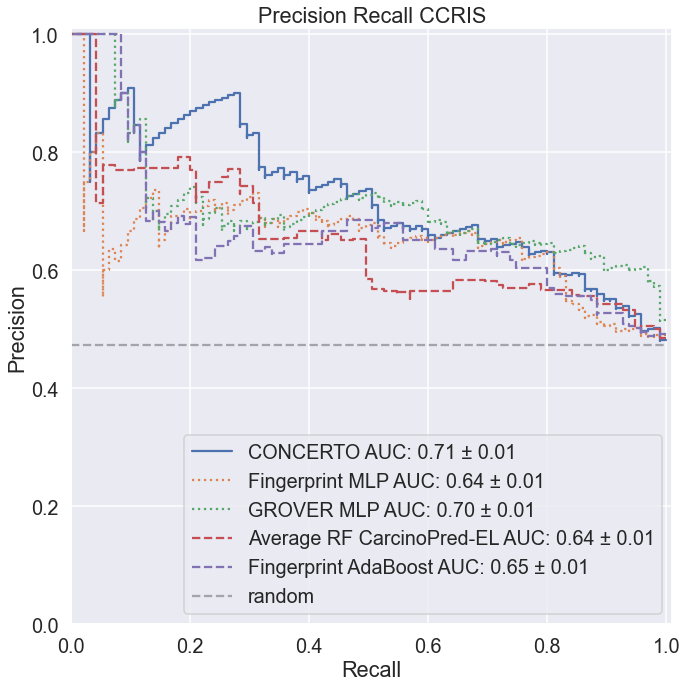

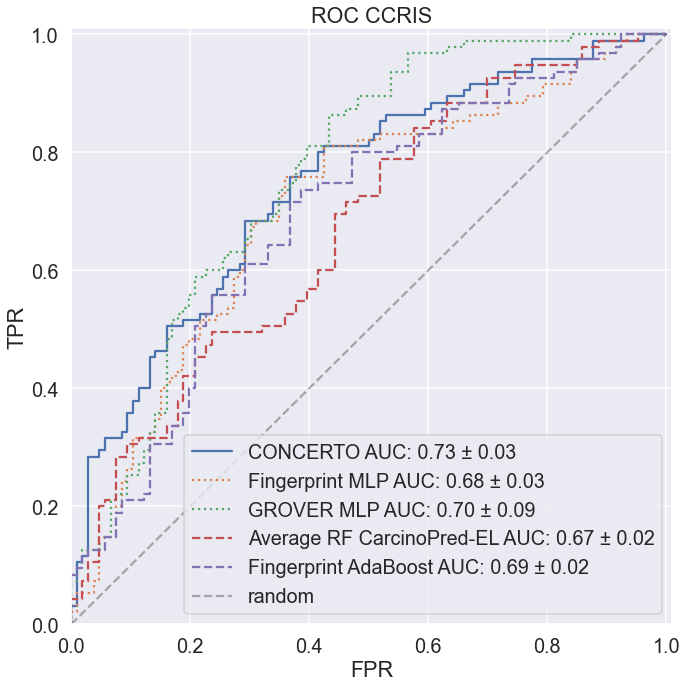

CNN backbone PR AUC: $0.69 \pm 0.01$
CNN backbone ROC AUC: $0.73 \pm 0.04$
CNN Baseline PR AUC: $0.51 \pm 0.01$
CNN Baseline ROC AUC: $0.49 \pm 0.01$
CONCERTO GIN PR AUC: $0.70 \pm 0.01$
CONCERTO GIN ROC AUC: $0.71 \pm 0.06$
CONCERTO PR AUC: $0.71 \pm 0.01$
CONCERTO ROC AUC: $0.73 \pm 0.03$
GAT backbone PR AUC: $0.72 \pm 0.01$
GAT backbone ROC AUC: $0.69 \pm 0.07$
Fingerprint MLP PR AUC: $0.64 \pm 0.01$
Fingerprint MLP ROC AUC: $0.68 \pm 0.03$
Fingerprint AdaBoost PR AUC: $0.65 \pm 0.01$
Fingerprint AdaBoost ROC AUC: $0.68 \pm 0.02$


In [27]:
predictor_name_dict = {
    'carc_pred_cnn':'CNN backbone',
    'carc_pred_gin':'CONCERTO GIN',
    'carc_pred_cnn_baseline':'CNN Baseline',
    'carc_pred_gat':'GAT backbone',
    'carc_pred_fp': 'CONCERTO',
    'rf_pred': 'Average RF CarcinoPred-EL',
    'Pubchem': 'Pubchem RF CarcinoPred-EL',
    'carc_pred_grover': 'GROVER MLP',
    'carc_pred_fp_baseline': 'Fingerprint MLP',
    'in_house_rf_pred': 'Fingerprint RF',
    'ada_boost_pred': 'Fingerprint AdaBoost'
    
}
sns.set()
sns.set_context('talk', font_scale=1.2)
figure_size = 10
df_name=held_out_carc
label_name='carc_label'

plt.figure(figsize=(figure_size, figure_size))

for predictor in viz_predictors:
    if predictor in ["Pubchem", "rf_pred", "CDK", 'in_house_rf_pred', 'ada_boost_pred']:
        linestyle="dashed"
    elif predictor in ["carc_pred_cnn_baseline", "carc_pred_fp_baseline", 'carc_pred_grover']:
        linestyle="dotted"
    else:
        linestyle='solid'
    add_pr_plot(
        df_name[predictor].values, df_name[label_name].values, 
        predictor_name_dict[predictor], linestyle=linestyle, add_auc=True,
    )
plt.xlabel('Recall')
plt.ylabel('Precision')
baseline_recall = sum(df_name[label_name] == 1) / len(df_name)
plt.plot(
    [0, 1], [baseline_recall, baseline_recall],
    linestyle='--', label='random', color='black', alpha=0.3
)
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.01])
# plt.title(f'Precision Recall Plot Held Out Test n={len(df_name)}')
plt.title(f'Precision Recall CCRIS')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../plots/PR_concerto_v2_CCRIS.pdf')

plt.show()

plt.figure(figsize=(figure_size, figure_size))
for predictor in viz_predictors:
    if predictor in ["Pubchem", "rf_pred", "CDK", 'in_house_rf_pred', 'ada_boost_pred']:
        linestyle="dashed"
    elif predictor in ["carc_pred_cnn_baseline", "carc_pred_fp_baseline", 'carc_pred_grover']:
        linestyle="dotted"
    else:
        linestyle='solid'

    add_roc_plot(
        df_name[predictor].values, df_name[label_name].values, 
        predictor_name_dict[predictor], linestyle=linestyle, add_auc=True
    )
#     delong_test(df_name[predictor].values, df_name[label_name].values, )
    print
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.01])
plt.xlim([0.0, 1.01])
plt.plot(
    [0, 1], [0, 1],
    linestyle='--', label='random', color='black', alpha=0.3
)
# plt.title(f"ROC Plot Held Out Test n={len(df_name)}")
plt.title(f"ROC CCRIS")
plt.legend()
plt.tight_layout()
plt.savefig('../plots/ROC_concerto_v2_CCRIS.pdf')

plt.show()

predictor_dict = {}
for predictor in predictors:
    outputs_roc, outputs_pr = computer_pr_roc_auc(
        df_name[predictor].values,
        df_name[label_name].values, 
        predictor_name_dict[predictor],
    )
    predictor_dict[predictor + "_roc"] = outputs_roc
    predictor_dict[predictor + '_pr'] = outputs_pr

In [14]:
test_0 = combine_data(*load_data_eval('test_0'),include_grover=False)
test_2 = combine_data(*load_data_eval('test_1'),include_grover=False)
test_1 = combine_data(*load_data_eval('test_2'),include_grover=False)

test = pd.concat([test_0, test_1, test_2])
test = test[~test['smiles'].duplicated()]
predictors = [
    'carc_pred_cnn',
    'carc_pred_cnn_baseline',
    'carc_pred_gin',
    'carc_pred_fp',
    'carc_pred_gat',
#     'rf_pred', 
    'carc_pred_fp_baseline',
    'ada_boost_pred'
#     'carc_pred_grover',
#     'Pubchem',
]
test_carc = test[
    (test['carc_continuous'].notnull()) 
#     (test['rf_pred'].notnull())
]
test_carc.reset_index(inplace=True)
print(len(test_carc))

g1 = load_data_eval('test_0')[-2]
g2 = load_data_eval('test_1')[-2]
g3 = load_data_eval('test_2')[-2]
grover_test = pd.concat([g1, g2, g3])
grover_test = grover_test[~grover_test['smiles'].duplicated()]
grover_test = grover_test[
    (grover_test['carc_continuous'].notnull()) 
]
grover_test.reset_index(inplace=True)
print(len(grover_test))

518
529


In [15]:
def make_scatterplot(
    x, y, df=test_carc, title="", xlabel="", ylabel="",
    save_dir="", save_name="", save_file=False, add_correlation=False
):
    plt.clf()
    r, p = stats.pearsonr(df[x], df[y])
    print(f'r={r:.3f}, p={p:.3f}')
    j = sns.jointplot(
        x=x, y=y, data = df, kind='scatter', height=8, xlim=[-2,3.5], alpha=0.3
    )
    if add_correlation:
        j.ax_joint.legend([f'r={r:.3f}, p={p:.3f}'],prop={'size': 20})

    j.ax_joint.set_xlabel(xlabel)
    j.ax_joint.set_ylabel(ylabel)

    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93) # Reduce plot to make room 
    if save_file:
        plt.savefig(f'{save_dir}/{save_name}')
    plt.show()

    

r=0.498, p=0.000


<Figure size 432x288 with 0 Axes>

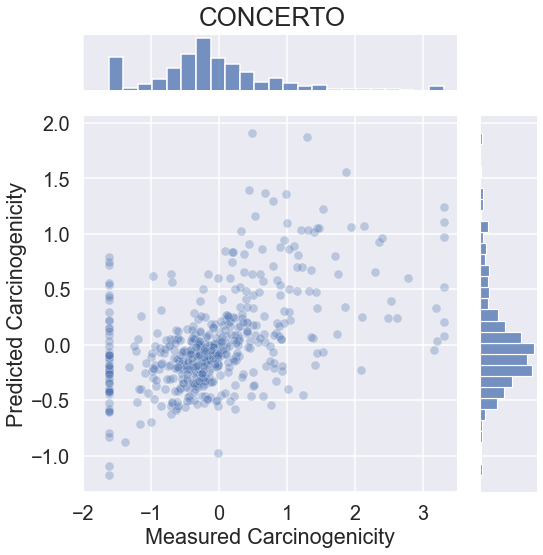

r=0.249, p=0.000


<Figure size 432x288 with 0 Axes>

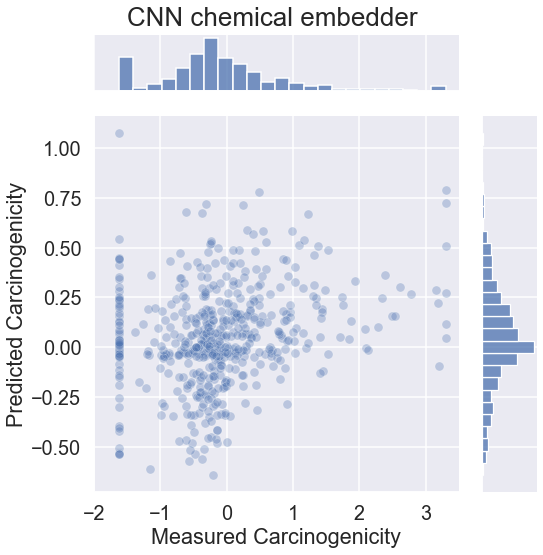

r=0.391, p=0.000


<Figure size 432x288 with 0 Axes>

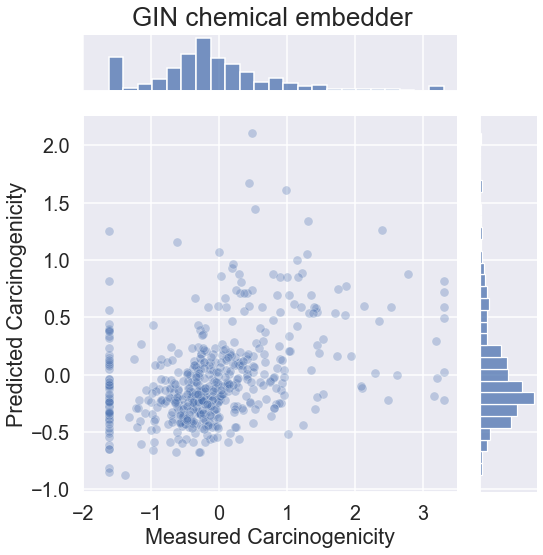

r=0.334, p=0.000


<Figure size 432x288 with 0 Axes>

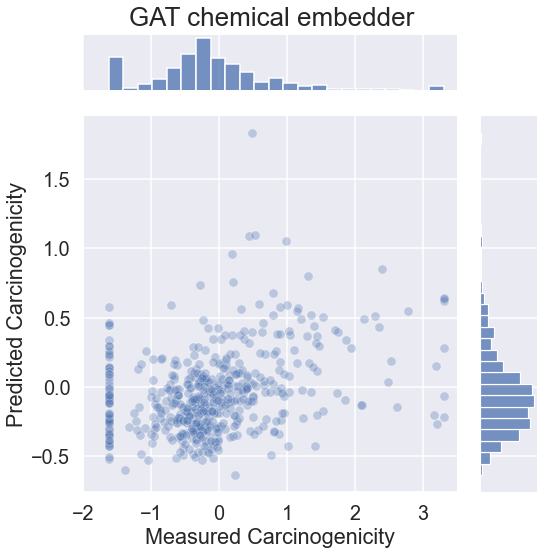

r=0.019, p=0.666


<Figure size 432x288 with 0 Axes>

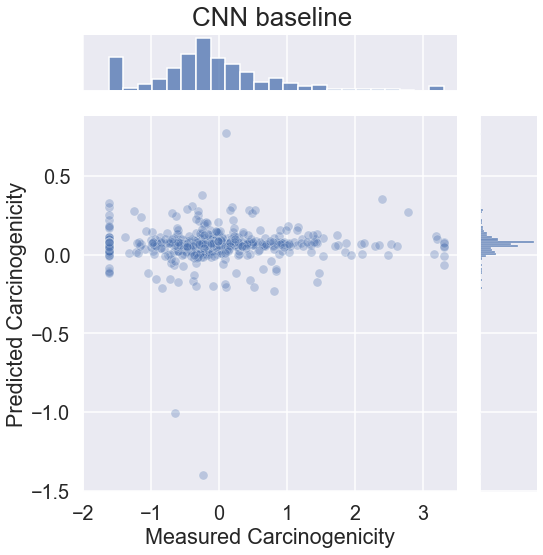

r=0.366, p=0.000


<Figure size 432x288 with 0 Axes>

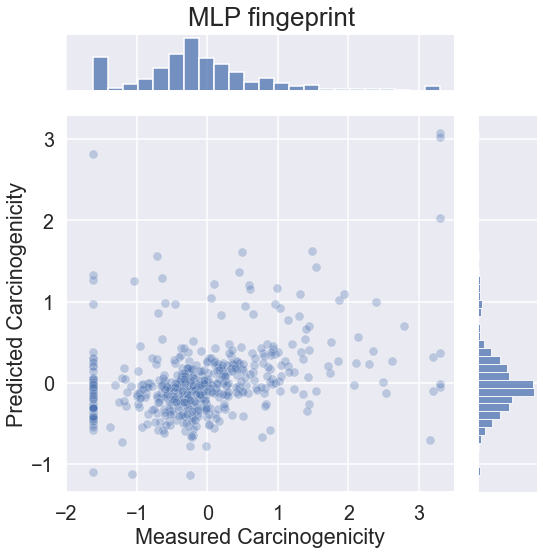

r=0.312, p=0.000


<Figure size 432x288 with 0 Axes>

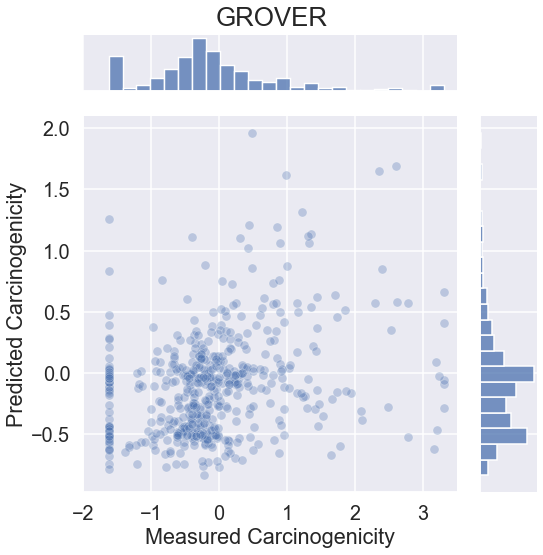

r=0.349, p=0.000


<Figure size 432x288 with 0 Axes>

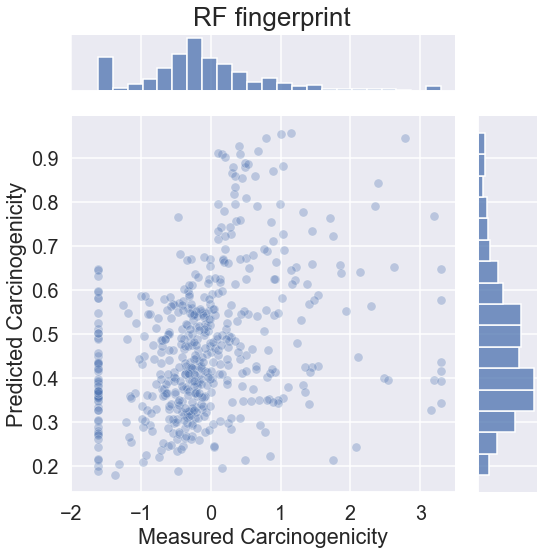

r=0.377, p=0.000


<Figure size 432x288 with 0 Axes>

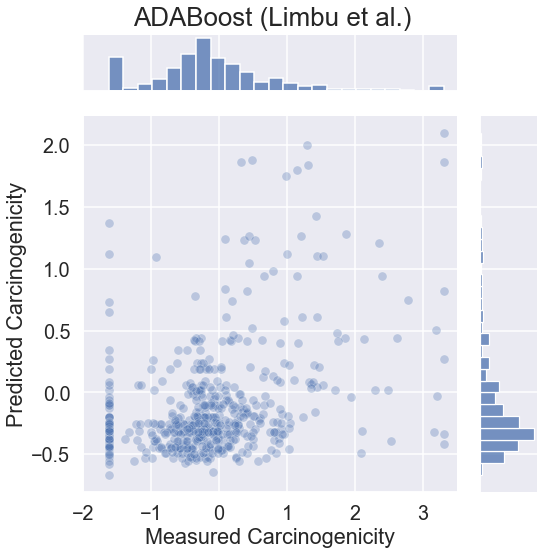

In [16]:
make_scatterplot(
    x = 'carc_continuous',
    y = 'carc_pred_fp',
    df= test_carc,
    title="CONCERTO",
    xlabel='Measured Carcinogenicity',
    ylabel='Predicted Carcinogenicity',
    save_file=True,
    save_dir='./../plots/',
    save_name='fingerprint_test_concerto_v2.pdf'
)
make_scatterplot(
    x = 'carc_continuous',
    y = 'carc_pred_cnn',
    df= test_carc,
    title="CNN chemical embedder",
    xlabel='Measured Carcinogenicity',
    ylabel='Predicted Carcinogenicity',
    save_file=True,
    save_dir='./../plots/',
    save_name='CNN_test_concerto_v2.pdf'
)
make_scatterplot(
    x = 'carc_continuous',
    y = 'carc_pred_gin',
    df= test_carc,
    title="GIN chemical embedder",
    xlabel='Measured Carcinogenicity',
    ylabel='Predicted Carcinogenicity',
    save_file=True,
    save_dir='./../plots/',
    save_name='gin_test_concerto_v2.pdf'
)
make_scatterplot(
    x = 'carc_continuous',
    y = 'carc_pred_gat',
    df= test_carc,
    title="GAT chemical embedder",
    xlabel='Measured Carcinogenicity',
    ylabel='Predicted Carcinogenicity',
    save_file=True,
    save_dir='./../plots/',
    save_name='gat_test_concerto_v2.pdf'
)
make_scatterplot(
    x = 'carc_continuous',
    y = 'carc_pred_cnn_baseline',
    df= test_carc,
    title="CNN baseline",
    xlabel='Measured Carcinogenicity',
    ylabel='Predicted Carcinogenicity',
    save_file=True,
    save_dir='./../plots/',
    save_name='cnn_baseline_test_concerto_v2.pdf'
)
make_scatterplot(
    x = 'carc_continuous',
    y = 'carc_pred_fp_baseline',
    df= test_carc,
    title="MLP fingeprint",
    xlabel='Measured Carcinogenicity',
    ylabel='Predicted Carcinogenicity',
    save_file=True,
    save_dir='./../plots/',
    save_name='fingerprint_baseline_test_concerto_v2.pdf'
)

make_scatterplot(
    x = 'carc_continuous',
    y = 'carc_pred_grover',
    df= grover_test,
    title="GROVER",
    xlabel='Measured Carcinogenicity',
    ylabel='Predicted Carcinogenicity',
    save_file=True,
    save_dir='./../plots/',
    save_name='grover_baseline_test_concerto_v2.pdf'
)

make_scatterplot(
    x = 'carc_continuous',
    y = 'in_house_rf_pred',
    df= test_carc,
    title="RF fingerprint",
    xlabel='Measured Carcinogenicity',
    ylabel='Predicted Carcinogenicity',
    save_file=True,
    save_dir='./../plots/',
    save_name='in_house_rf_baseline_test_concerto_v2.pdf'
)

make_scatterplot(
    x = 'carc_continuous',
    y = 'ada_boost_pred',
    df= test_carc,
    title="ADABoost (Limbu et al.)",
    xlabel='Measured Carcinogenicity',
    ylabel='Predicted Carcinogenicity',
    save_file=True,
    save_dir='./../plots/',
    save_name='adaboost_limbu_test_concerto_v2.pdf'
)

In [17]:
x_names = ['carc_pred_cnn', 'carc_pred_gin', 'carc_pred_fp', 
           'carc_pred_gat', 'carc_pred_cnn_baseline', 'carc_pred_fp_baseline',
           'rf_pred', 'CDK', 'in_house_rf_pred', 'ada_boost_pred']

for x in x_names:
    print('\n')
    print(x)
    y = 'carc_continuous'
    vals = bootstrap(
        lambda x, y: np.mean((x - y)**2),
        test_carc[x].values,
        test_carc[y].values,
        itrs = 100
    )
    r,p = stats.pearsonr(
        test_carc[x].values,
        test_carc[y].values,
    )
    print(f"""${np.mean((test_carc[x].values - test_carc[y].values)**2):.2f}$""")
    print(np.mean(vals), np.std(vals))
    print(
        f'${np.mean(vals):.2f} '
        f'\pm {np.std(vals):.2f}$'
    )

vals = bootstrap(
    lambda x, y: np.mean((x - y)**2),
    grover_test['carc_pred_grover'].values,
    grover_test['carc_continuous'].values,
    itrs = 100
)
r,p = stats.pearsonr(
    grover_test['carc_pred_grover'].values,
    grover_test['carc_continuous'].values,
)
print('\n')
print('carc_pred_grover')
print(np.mean(vals), np.std(vals))
print(
    f'${np.mean(vals):.2f} '
    f'\pm {np.std(vals):.2f}$'
)




carc_pred_cnn
$0.88$
0.8693924030795012 0.06482383776905001
$0.87 \pm 0.06$


carc_pred_gin
$0.78$
0.7759037732822743 0.05992373993867971
$0.78 \pm 0.06$


carc_pred_fp
$0.70$
0.6935441611049166 0.06148203558115859
$0.69 \pm 0.06$


carc_pred_gat
$0.81$
0.8065022067878336 0.0636708111686775
$0.81 \pm 0.06$


carc_pred_cnn_baseline
$0.95$
0.9414950997657041 0.08002414832153693
$0.94 \pm 0.08$


carc_pred_fp_baseline
$0.81$
0.8160422884910078 0.07860202271134498
$0.82 \pm 0.08$


rf_pred
$1.07$
1.0761762173458898 0.059072694462805456
$1.08 \pm 0.06$


CDK
$1.08$
1.075263981726477 0.05688408164042241
$1.08 \pm 0.06$


in_house_rf_pred
$1.16$
1.1731516110733486 0.06660719935149931
$1.17 \pm 0.07$


ada_boost_pred
$0.79$
0.7952566499420621 0.07725978202052249
$0.80 \pm 0.08$


carc_pred_grover
0.8404070893526213 0.0836174174505482
$0.84 \pm 0.08$


In [18]:
x_names = ['carc_pred_cnn', 'carc_pred_gin', 'carc_pred_fp', 
           'carc_pred_gat', 'carc_pred_cnn_baseline', 'carc_pred_fp_baseline',
           'rf_pred', 'CDK', 'in_house_rf_pred', 'ada_boost_pred']

for x in x_names:
    print('\n')
    print(x)
    y = 'carc_continuous'
    vals = bootstrap(
        stats.pearsonr,
        test_carc[x].values,
        test_carc[y].values,
        itrs = 1000
    )
    r,p = stats.pearsonr(
        test_carc[x].values,
        test_carc[y].values,
    )

    print(f'r={r:.3f}, p={p:.3f}')
    print(
        f'mean r={np.mean([x[0] for x in vals]):.3f}',
        f'std r={np.std([x[0] for x in vals]):.3f}'
    )
    print(f'${np.mean([x[0] for x in vals]):.2f} \pm {np.std([x[0] for x in vals]):.2f}$'
    )

vals = bootstrap(
    stats.pearsonr,
    grover_test['carc_pred_grover'].values,
    grover_test['carc_continuous'].values,
    itrs = 100
)
r,p = stats.pearsonr(
    grover_test['carc_pred_grover'].values,
    grover_test['carc_continuous'].values,
)
print('\n')
print('carc_pred_grover')
print(f'r={r:.3f}, p={p:.3f}')
print(np.mean(vals), np.std(vals))
print(
    f'${np.mean(vals):.2f} '
    f'\pm {np.std(vals):.2f}$'
)




carc_pred_cnn
r=0.249, p=0.000
mean r=0.250 std r=0.044
$0.25 \pm 0.04$


carc_pred_gin
r=0.391, p=0.000
mean r=0.393 std r=0.042
$0.39 \pm 0.04$


carc_pred_fp
r=0.498, p=0.000
mean r=0.499 std r=0.038
$0.50 \pm 0.04$


carc_pred_gat
r=0.334, p=0.000
mean r=0.334 std r=0.043
$0.33 \pm 0.04$


carc_pred_cnn_baseline
r=0.019, p=0.666
mean r=0.019 std r=0.034
$0.02 \pm 0.03$


carc_pred_fp_baseline
r=0.366, p=0.000
mean r=0.363 std r=0.066
$0.36 \pm 0.07$


rf_pred
r=0.496, p=0.000
mean r=0.499 std r=0.035
$0.50 \pm 0.03$


CDK
r=0.442, p=0.000
mean r=0.442 std r=0.035
$0.44 \pm 0.04$


in_house_rf_pred
r=0.349, p=0.000
mean r=0.349 std r=0.039
$0.35 \pm 0.04$


ada_boost_pred
r=0.377, p=0.000
mean r=0.377 std r=0.050
$0.38 \pm 0.05$


carc_pred_grover
r=0.312, p=0.000
0.15300998468920102 0.15680443111959894
$0.15 \pm 0.16$


In [32]:
delong_preds = [
    'carc_pred_cnn',
    'carc_pred_fp',
    'carc_pred_cnn_baseline',
    'carc_pred_gin',
    'carc_pred_gat',
    'rf_pred', 
    'carc_pred_fp_baseline',
    'carc_pred_grover',
    'Pubchem',
    'in_house_rf_pred',
    'ada_boost_pred'
]

for x in delong_preds:
    full_o = delong_test(
            held_out_carc[held_out_carc['carc_label'] == 1][[x, 'carc_pred_fp']].values, 
            held_out_carc[held_out_carc['carc_label'] == 0][[x, 'carc_pred_fp']].values,
            'lower',
            0.05)
    
    print(x, round(full_o['p'],2), full_o)

carc_pred_cnn 0.67 {'T': 0.4299972445013117, 'p': 0.6664011771915999, 'lower_CI': -0.11561426692133266, 'Upper_CI': None}
carc_pred_fp nan {'T': nan, 'p': nan, 'lower_CI': -0.11366160793256685, 'Upper_CI': None}
carc_pred_cnn_baseline 0.0 {'T': -4.275834681455678, 'p': 9.521124730829051e-06, 'lower_CI': 0.1622476439944087, 'Upper_CI': None}
carc_pred_gin 0.55 {'T': 0.13340904869138906, 'p': 0.5530650552215766, 'lower_CI': -0.11203343485963008, 'Upper_CI': None}
carc_pred_gat 0.48 {'T': -0.061694435552971695, 'p': 0.47540308565767553, 'lower_CI': -0.10337176647371757, 'Upper_CI': None}
rf_pred 0.05 {'T': -1.6781305381386524, 'p': 0.046660809141163884, 'lower_CI': -0.036627555092005284, 'Upper_CI': None}
carc_pred_fp_baseline 0.11 {'T': -1.2181005653860209, 'p': 0.11159287953331565, 'lower_CI': -0.06526782431864249, 'Upper_CI': None}
carc_pred_grover 0.8 {'T': 0.8576389206297792, 'p': 0.8044540616591308, 'lower_CI': -0.1243688633019678, 'Upper_CI': None}
Pubchem 0.01 {'T': -2.53337174359